In [1]:
# Time Series Forecasting With Prophet in Python
#     https://machinelearningmastery.com/time-series-forecasting-with-prophet-in-python/

# Facebook Prophet
#     https://medium.com/swlh/facebook-prophet-426421f7e331

# Previsão de Séries Temporais | Tutorial sobre Prophet
#     https://www.youtube.com/watch?v=CW1PZwNG-wQ&ab_channel=SynapseDataScience

# Time Series Analysis with Facebook's Prophet
#     https://www.youtube.com/watch?v=iHAbGg523UQ&ab_channel=JCharisTech

# Stock Price Prediction Using Facebook Prophet, Machine Learning & Python
#     https://www.youtube.com/watch?v=d5oT8KeGouw&ab_channel=ComputerScience

In [122]:
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
import sklearn as skl
from sklearn import metrics
import numpy as np
from prophet import Prophet

In [123]:
#Definindo o dataframe "inicial" a partir dos dados de uma acao com o yahoo finance
vale = yf.Ticker('VALE')

history = vale.history(period="max")
df = pd.DataFrame(history)


In [124]:
#Dataframe pré tratamento
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2002-03-21 00:00:00-05:00,0.902664,0.902664,0.902664,0.902664,0,0.0,0.0
2002-03-22 00:00:00-05:00,0.894306,0.894306,0.866891,0.874246,44247600,0.0,0.0
2002-03-25 00:00:00-05:00,0.870903,0.877589,0.869232,0.874246,7429200,0.0,0.0
2002-03-26 00:00:00-05:00,0.874247,0.897649,0.874247,0.897315,4604400,0.0,0.0
2002-03-27 00:00:00-05:00,0.900992,0.927738,0.895977,0.911021,13928400,0.0,0.0
...,...,...,...,...,...,...,...
2023-06-16 00:00:00-04:00,14.330000,14.550000,14.280000,14.440000,20757200,0.0,0.0
2023-06-20 00:00:00-04:00,14.240000,14.240000,14.010000,14.050000,24522800,0.0,0.0
2023-06-21 00:00:00-04:00,14.000000,14.040000,13.900000,13.980000,25521500,0.0,0.0


In [125]:
#Retirando colunas, e mantendo apenas Data e Close
df.drop(columns=['Open', 'High', 'Low', 'Volume', 'Dividends', 'Stock Splits'], inplace=True)

#Alterando a data de Index para Column
df.reset_index(inplace=True)

#Alterando os nomes para funcionarem com a biblioteca Prophet
df.columns=['ds','y']

df['ds'] = pd.to_datetime(df.ds)

#Remove o timezone da coluna ds
df['ds'] = df['ds'].dt.tz_localize(None)

#Deletando os X primeiros anos
#df.drop(df.index[:(20*365)], inplace=True)
#TIVE A IDEIA DE "APAGAR" OS PRIMEIROS ANOS DE AAPL PQ ERAM EXTREMAMENTE LINEARES E AFETAVAM UM POUCO A PRECISAO DA PREDICAO. DE QUALQUER MANEIRA PASSEI A USAR VALE COMO EXEMPLO, POR NENHUM MOTIVO ESPECIFICO, E NAO ACHEI NECESSARIO MAIS USAR ISSO.


In [126]:
#Dataframe pós tratamento
df

,ds,y
0,2002-03-21,0.902664
1,2002-03-22,0.874246
2,2002-03-25,0.874246
3,2002-03-26,0.897315
4,2002-03-27,0.911021
...,...,...
5347,2023-06-16,14.440000
5348,2023-06-20,14.050000
5349,2023-06-21,13.980000
5350,2023-06-22,13.910000


In [127]:
df.describe()

,y
count,5352.000000
mean,8.783998
std,5.015876
min,0.727146
25%,4.757283
50%,8.778571
75%,12.794999
max,21.273159


In [128]:
#Separando parte de treino e teste
#90% - Treino | 10% - Teste
df_90_size = int(round(len(df) * 0.9))

df_train = df[:df_90_size] # "Historic"
df_test = df[df_90_size:] # "Future"

In [129]:
df_train

,ds,y
0,2002-03-21,0.902664
1,2002-03-22,0.874246
2,2002-03-25,0.874246
3,2002-03-26,0.897315
4,2002-03-27,0.911021
...,...,...
4812,2021-05-03,16.529451
4813,2021-05-04,16.768055
4814,2021-05-05,17.056023
4815,2021-05-06,17.977528


In [130]:
df_test

,ds,y
4817,2021-05-10,18.142080
4818,2021-05-11,18.685108
4819,2021-05-12,17.829430
4820,2021-05-13,17.500320
4821,2021-05-14,17.302855
...,...,...
5347,2023-06-16,14.440000
5348,2023-06-20,14.050000
5349,2023-06-21,13.980000
5350,2023-06-22,13.910000


<AxesSubplot: xlabel='ds'>

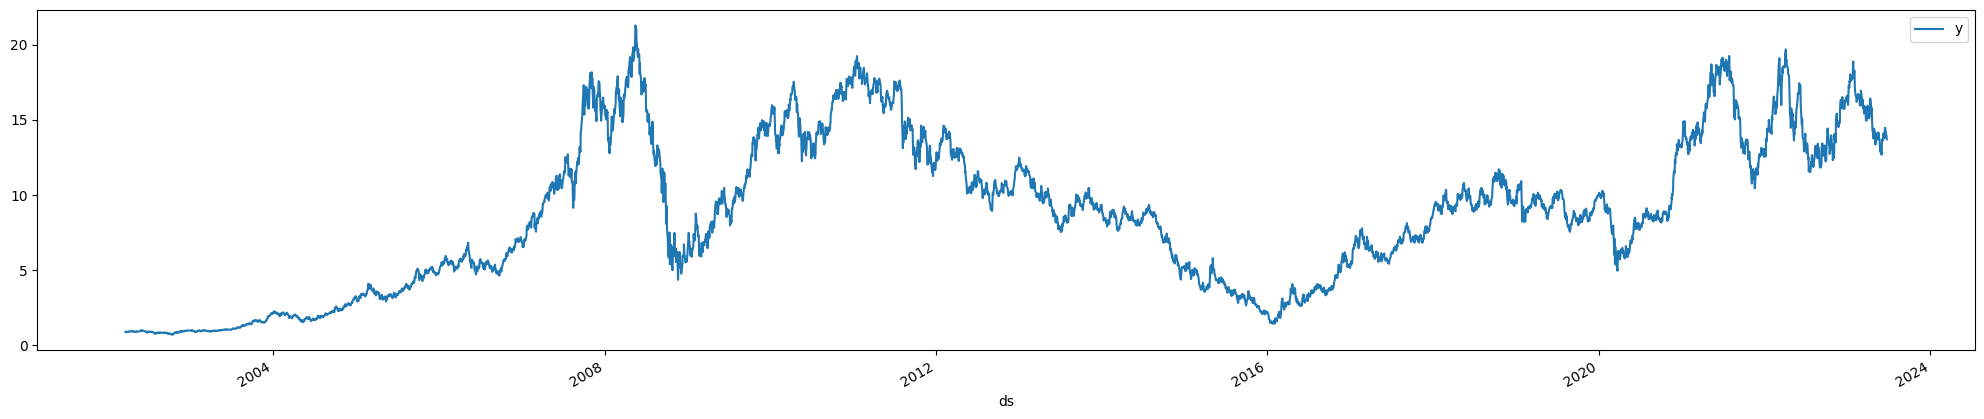

In [131]:
df.plot(x='ds', y='y', figsize=(25,5))

In [132]:
# Funcao criada pelo Chat GPT
# Usa a numpy para calcular o sMAPE da previsao
def calculate_smape(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    denominator = np.abs(y_true) + np.abs(y_pred) # Soma dos valores absolutos
    diff = np.abs(y_true - y_pred) / denominator # Soma das diferencas absolutas / a soma dos valores absolutos
    smape = 2 * np.mean(diff) * 100
    
    return round(smape,2)
  

In [133]:
# Gera um grafico com as metricas de erro
def analise_de_erro(df, forecast):
    len_df = len(df)
    len_forecast = len(forecast)

    # Definindo o tamanho do dataframe maior igual ao tamanho do menor
    if len_df < len_forecast:
        forecast = forecast[:len_df]
    elif len_df > len_forecast:
        df = df[:len_forecast]
    
    fig, ax = plt.subplots(figsize=(20, 5))

    ax.plot(df['ds'], df['y'], label='Real')
    ax.plot(forecast['ds'], forecast['yhat'], label='Previsão', color='red')
    ax.axhline(y=0, color='black')

    ax.legend()

    ax.margins(x=0.01)

    ax.set_title('Análise de erro')


    # Calculando MAPE
    mape = skl.metrics.mean_absolute_percentage_error(df['y'], forecast['yhat'])
    mape = round(100 * mape, 2)

    # Calculando sMAPE
    smape = calculate_smape(df['y'], forecast['yhat'])

    # Calculando MAE
    mae = skl.metrics.mean_absolute_error(df['y'], forecast['yhat'])
    mae = round(mae, 2)

    # Calculando MSE
    mse = skl.metrics.mean_squared_error(df['y'], forecast['yhat'])
    mse = round(mse, 2)

    # Calculando RMSE
    rmse = round(skl.metrics.mean_squared_error(df['y'], forecast['yhat'], squared=False), 2)

    ax.text(0.5, -0.2, f"\nMAPE: % {str(mape)}\nsMAPE: % {str(smape)}\nMAE: {str(mae)}\nMSE: {str(mse)}\nRMSE: {str(rmse)}", ha='center', va='center', transform=ax.transAxes, fontsize=12)


    plt.show()

In [134]:
#Funcao criada com gpt para plot de graficos com labels
def plot_forecast(df, forecast, x_label, y_label, title, text_description):
    # Plotting the forecast
    fig, ax = plt.subplots(figsize=(25, 5))
    df.plot(forecast, ax=ax)

    # Modifying the axis labels
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)

    # Adding a title
    ax.set_title(title)

    # Adicionar texto abaixo dos gráficos
    ax.text(0.5, -0.2, text_description+'\n', ha='center', va='center', transform=ax.transAxes, fontsize=12)

    # Displaying the plot
    plt.show()

In [135]:
#Realizando a predicao pelas instrucoes do site oficial do modelo. https://facebook.github.io/prophet/docs/quick_start.html#python-api
#Usa 100% para treinar o modelo e preve 365 dias

In [136]:
#Treinando o modelo com o df (total) 
m = Prophet()
m.fit(df)

#Criando um dataframe com uma coluna, ds, contendo as datas (1 ano) futuras que serao usadas nas predicoes.
future = m.make_future_dataframe(periods=365)
#future.tail()

# "predict method will assign each row in future a predicted value which it names yhat"
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail() #Colunas mais relevantes

18:05:50 - cmdstanpy - INFO - Chain [1] start processing
18:05:51 - cmdstanpy - INFO - Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper
5712,2024-06-18,18.054617,15.240864,20.821545
5713,2024-06-19,18.055071,15.128779,21.165315
5714,2024-06-20,18.048275,15.279033,21.095361
5715,2024-06-21,18.042925,15.209995,21.083522
5716,2024-06-22,18.291156,15.304514,21.114406


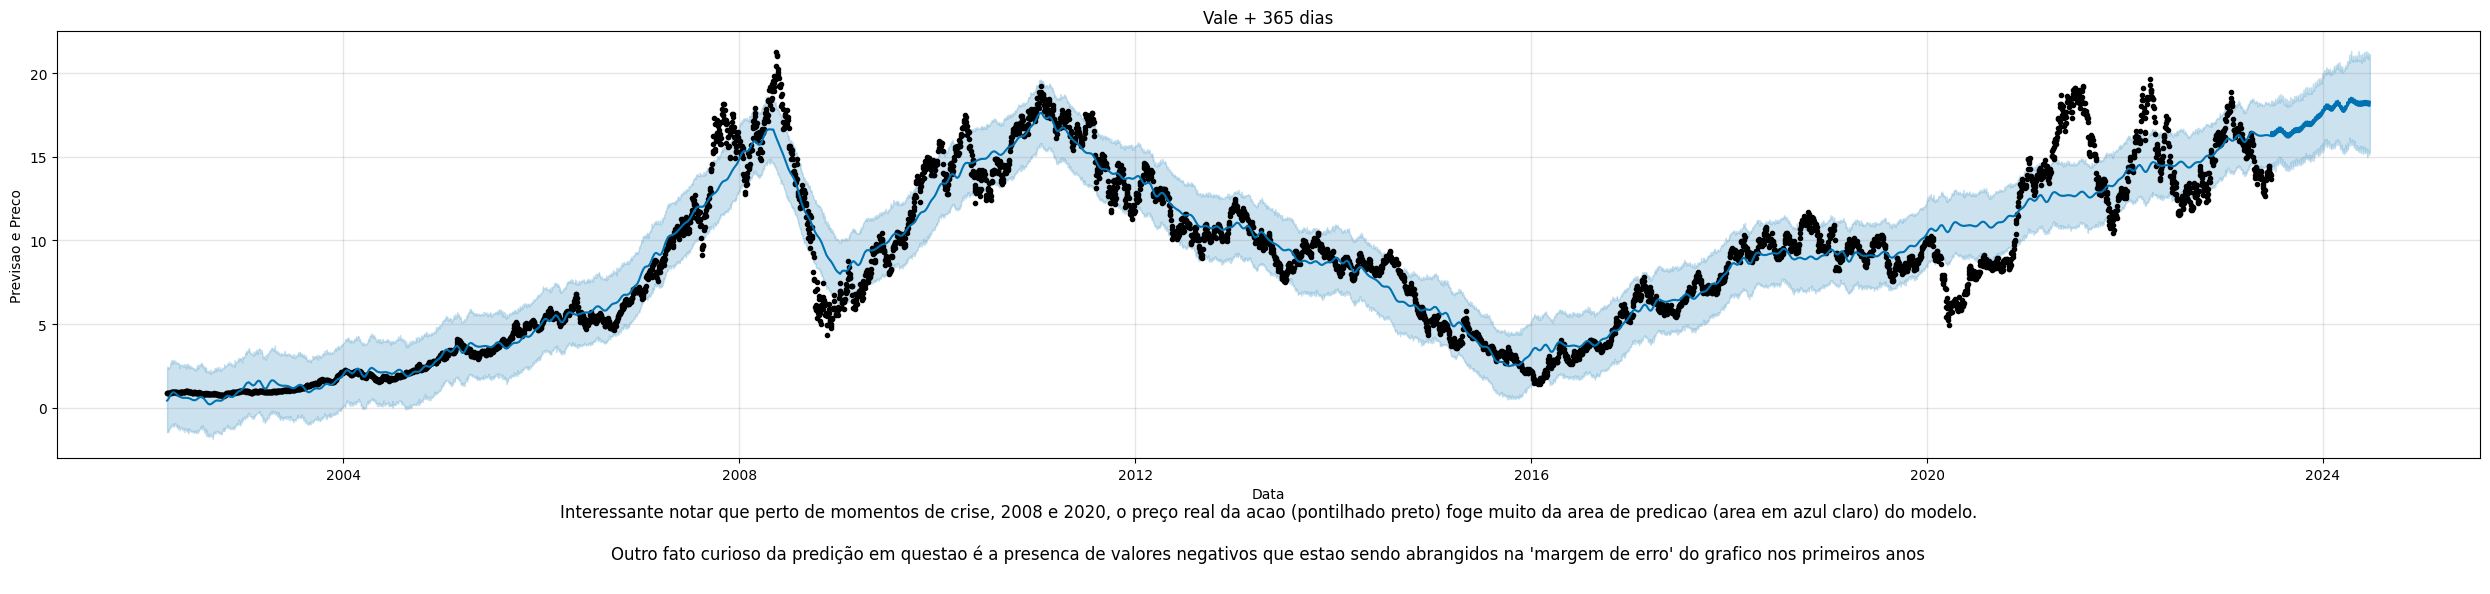

In [137]:
#fig1 = m.plot(forecast)
plot_forecast(m, forecast,"Data", "Previsao e Preco", "Vale + 365 dias", "Interessante notar que perto de momentos de crise, 2008 e 2020, o preço real da acao (pontilhado preto) foge muito da area de predicao (area em azul claro) do modelo.\n\nOutro fato curioso da predição em questao é a presenca de valores negativos que estao sendo abrangidos na 'margem de erro' do grafico nos primeiros anos")


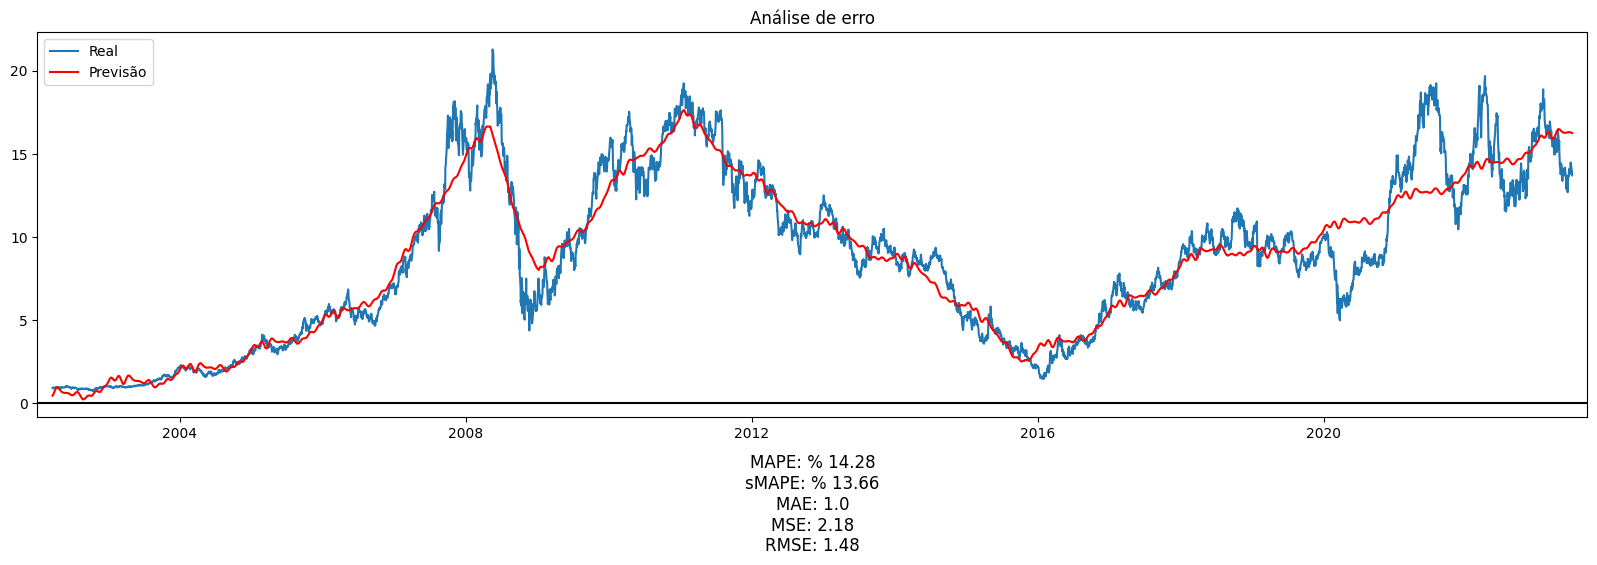

In [138]:
analise_de_erro(df, forecast)

In [139]:
#Realizando a predicao seguindo alguns tutoriais diferentes

#obs.: METODO 1 e 2 mudam apenas o "quanto" irao prever

In [140]:
#METODO 0 - Utilizando os novos casos de Covid-19 como variavel explicativa para o preço de VALE
#Utiliza df_train (80%) para treinar o modelo e preve 365 dias.

#Adicionando dataframe de covid
df_covid = pd.read_csv("WHO-COVID-19-global-data.csv")

#Selecionando o pais desejado (csv possui numero de casos de todos paises)
df_covid = df_covid[df_covid["Country"] == "Brazil"]

#Selecionando os dados relevantes e renomeando
df_covid = df_covid [["Date_reported", "New_cases"]]
df_covid.columns = ["ds", "new_cases"]

#Ajustando a coluna "ds" para o tipo datetime
df_covid["ds"] = pd.to_datetime(df_covid["ds"])

df_covid.head(750)

,ds,new_cases
34664,2020-01-03,0
34665,2020-01-04,0
34666,2020-01-05,0
34667,2020-01-06,0
34668,2020-01-07,0
...,...,...
35409,2022-01-17,48520
35410,2022-01-18,24934
35411,2022-01-19,74134
35412,2022-01-20,137103


In [141]:
#Adicionando os dados de covid no df de treino
df_train_covid = pd.merge(df_train, df_covid, on="ds", how="left")

df_train_covid["new_cases"].fillna(0, inplace=True)

df_train_covid.head(5000)

,ds,y,new_cases
0,2002-03-21,0.902664,0.0
1,2002-03-22,0.874246,0.0
2,2002-03-25,0.874246,0.0
3,2002-03-26,0.897315,0.0
4,2002-03-27,0.911021,0.0
...,...,...,...
4812,2021-05-03,16.529451,66964.0
4813,2021-05-04,16.768055,28935.0
4814,2021-05-05,17.056023,24619.0
4815,2021-05-06,17.977528,77359.0


In [142]:
#Treinando o modelo com o dataframe de treino + covid
m0 = Prophet(daily_seasonality=True)
m0.add_regressor("new_cases")
m0.fit(df_train_covid)

#Criando um dataframe com datas futuras (365 a frente do tempo)
future0 = m0.make_future_dataframe(periods=365)

# Merge do dataframe future com of dataframe de novos casos de covid
future0 = pd.merge(future0, df_covid, on='ds', how='left')
future0["new_cases"].fillna(0, inplace=True)
                                          
#Fazendo a predicao para datas futuras, do dataframe future1, usando o modelo treinado pelo df_train
forecast0 = m0.predict(future0)


18:05:53 - cmdstanpy - INFO - Chain [1] start processing
18:05:56 - cmdstanpy - INFO - Chain [1] done processing


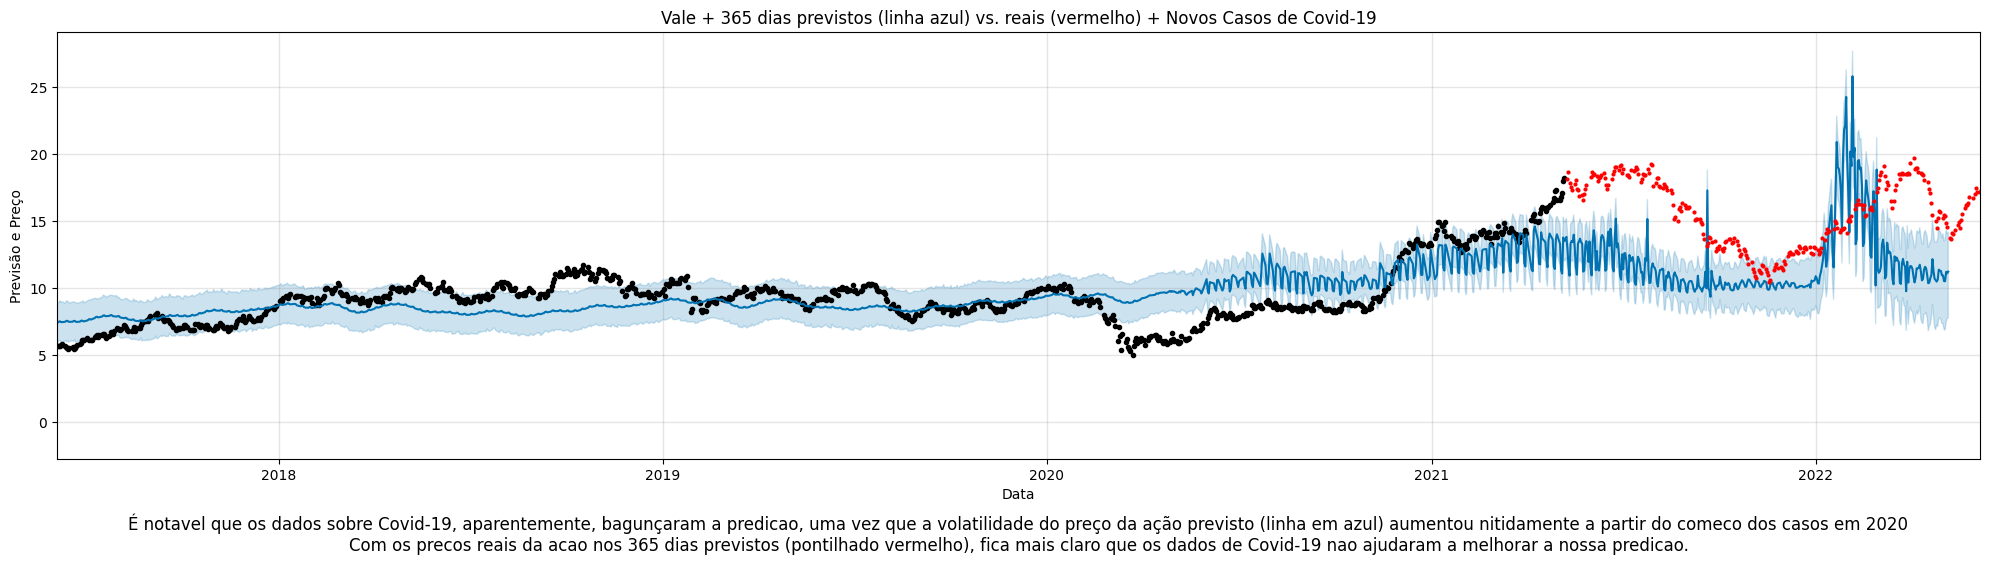

In [143]:
#Plotando os graficos do df_test(vermelho) e m0+forecast0(Preto + Azul) com matplotib para comparar predicao x real

# Cria uma figura e um subplot
fig, axes = plt.subplots(figsize=(20, 5))

# Plotar a previsão (forecast1) gerada pelo modelo
m0.plot(forecast0, ax=axes)

# Plotar os dados de teste (df_test) no mesmo subplot
axes.plot(df_test['ds'], df_test['y'], 'ro', markersize=2)

# Adicionar título e rótulos dos eixos
axes.set_title("Vale + 365 dias previstos (linha azul) vs. reais (vermelho) + Novos Casos de Covid-19")
axes.set_xlabel("Data")
axes.set_ylabel("Previsão e Preço")

# Definir limites do eixo x para mostrar apenas a segunda metade do gráfico
x_min, x_max = axes.get_xlim()
axes.set_xlim(x_max/1.15, x_max-770) #Gambiarra para limitar a janela do plot

# Adicionar texto abaixo dos gráficos
axes.text(0.5, -0.2, "É notavel que os dados sobre Covid-19, aparentemente, bagunçaram a predicao, uma vez que a volatilidade do preço da ação previsto (linha em azul) aumentou nitidamente a partir do comeco dos casos em 2020\nCom os precos reais da acao nos 365 dias previstos (pontilhado vermelho), fica mais claro que os dados de Covid-19 nao ajudaram a melhorar a nossa predicao.\n", ha='center', va='center', transform=axes.transAxes, fontsize=12)


# Mostrar a figura
plt.show()


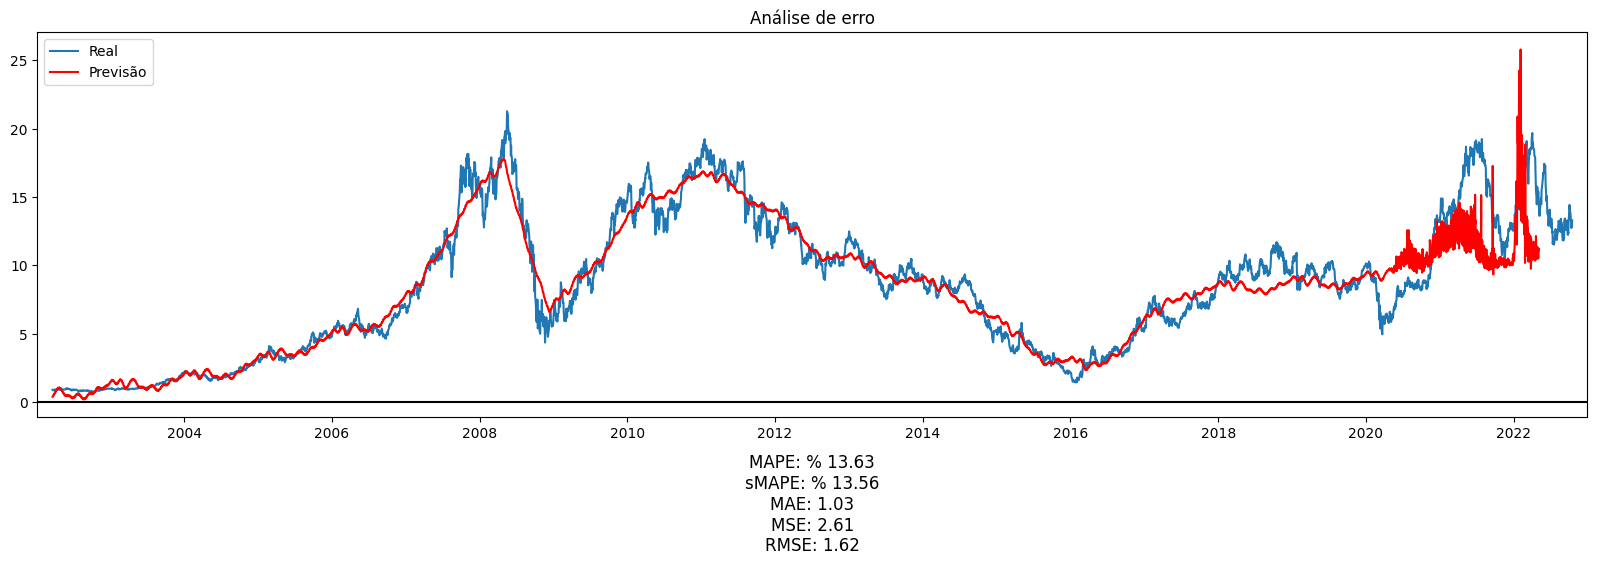

In [144]:
analise_de_erro(df, forecast0)

In [145]:
#METODO 1 - Treinando com df_train, prevendo 365 dias e checando com df_test

#Treinando o modelo com o dataframe de treino
m1 = Prophet(daily_seasonality=True)
m1.fit(df_train)

#Criando um dataframe com datas futuras (365 a frente do tempo)
future1 = m1.make_future_dataframe(periods=365)

#Fazendo a predicao para datas futuras, do dataframe future1, usando o modelo treinado pelo df_train
forecast1 = m1.predict(future1)


18:05:57 - cmdstanpy - INFO - Chain [1] start processing
18:05:59 - cmdstanpy - INFO - Chain [1] done processing


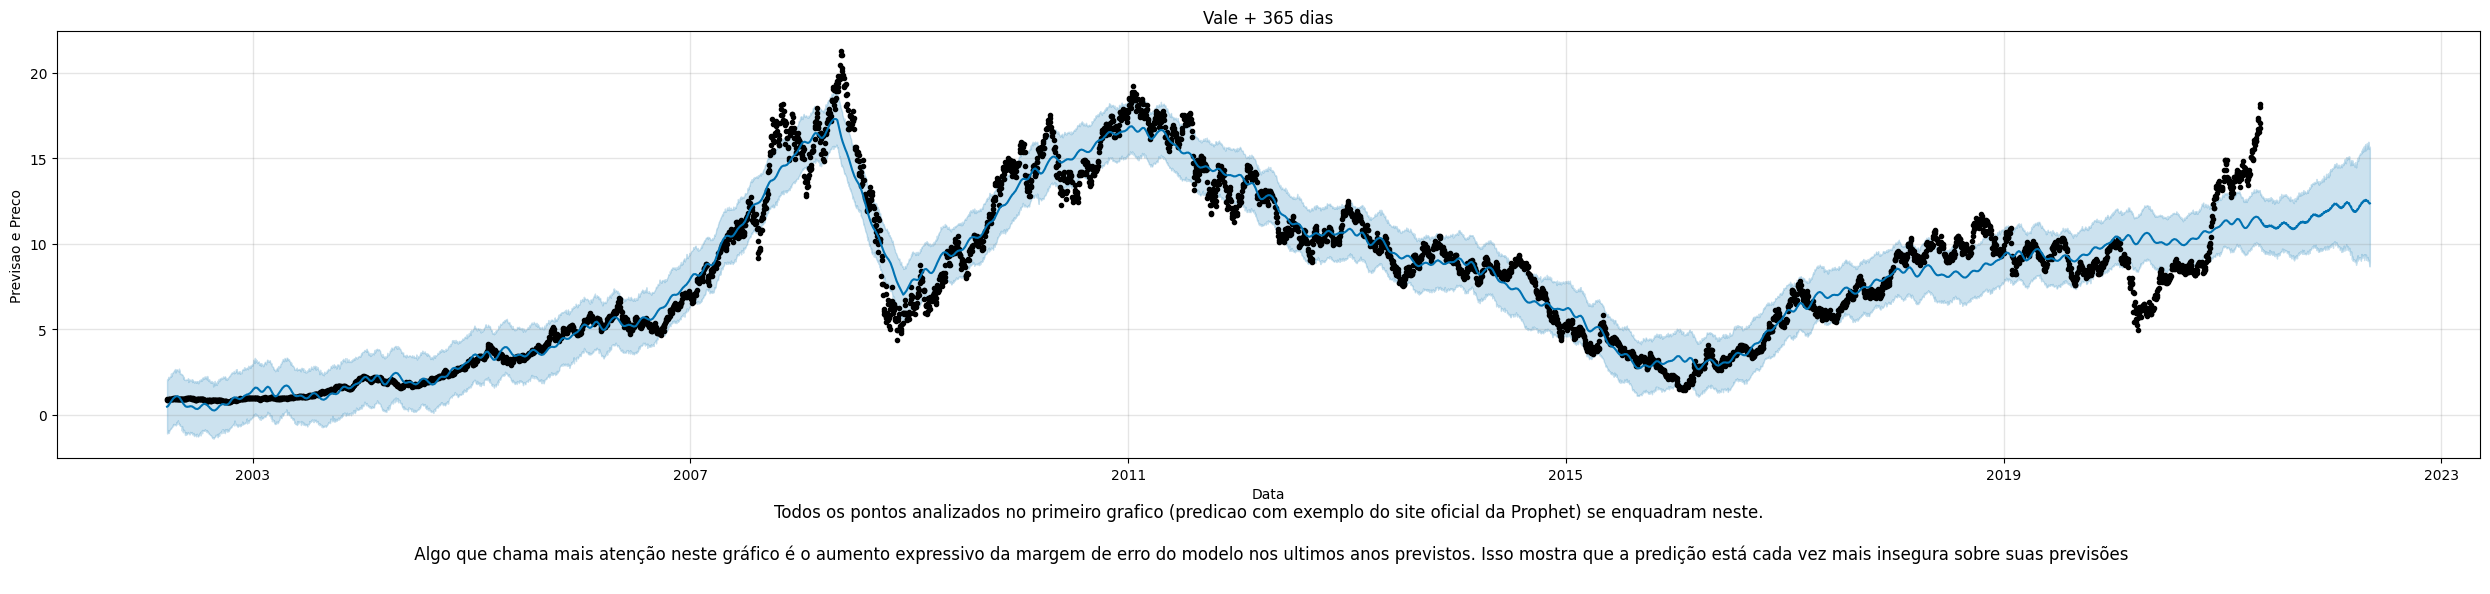

In [146]:
#m1.plot(forecast1)
plot_forecast(m1, forecast1,"Data", "Previsao e Preco", "Vale + 365 dias", "Todos os pontos analizados no primeiro grafico (predicao com exemplo do site oficial da Prophet) se enquadram neste.\n\n Algo que chama mais atenção neste gráfico é o aumento expressivo da margem de erro do modelo nos ultimos anos previstos. Isso mostra que a predição está cada vez mais insegura sobre suas previsões")

In [147]:
#Criando um df que vai do fim de df_train até 365 a frente, e que contenha os dados corretos

#Criando o dataframe df_future1 com as datas do future1
df_future1 = pd.DataFrame({'ds': future1['ds']})

#Adicionando os y's do df_test que correspondem às datas do df_future
df_future1 = df_future1.merge(df_test[['ds', 'y']], on='ds', how='inner')

df_future1

,ds,y
0,2021-05-10,18.142080
1,2021-05-11,18.685108
2,2021-05-12,17.829430
3,2021-05-13,17.500320
4,2021-05-14,17.302855
...,...,...
247,2022-05-02,15.190354
248,2022-05-03,15.422056
249,2022-05-04,15.384984
250,2022-05-05,14.838169


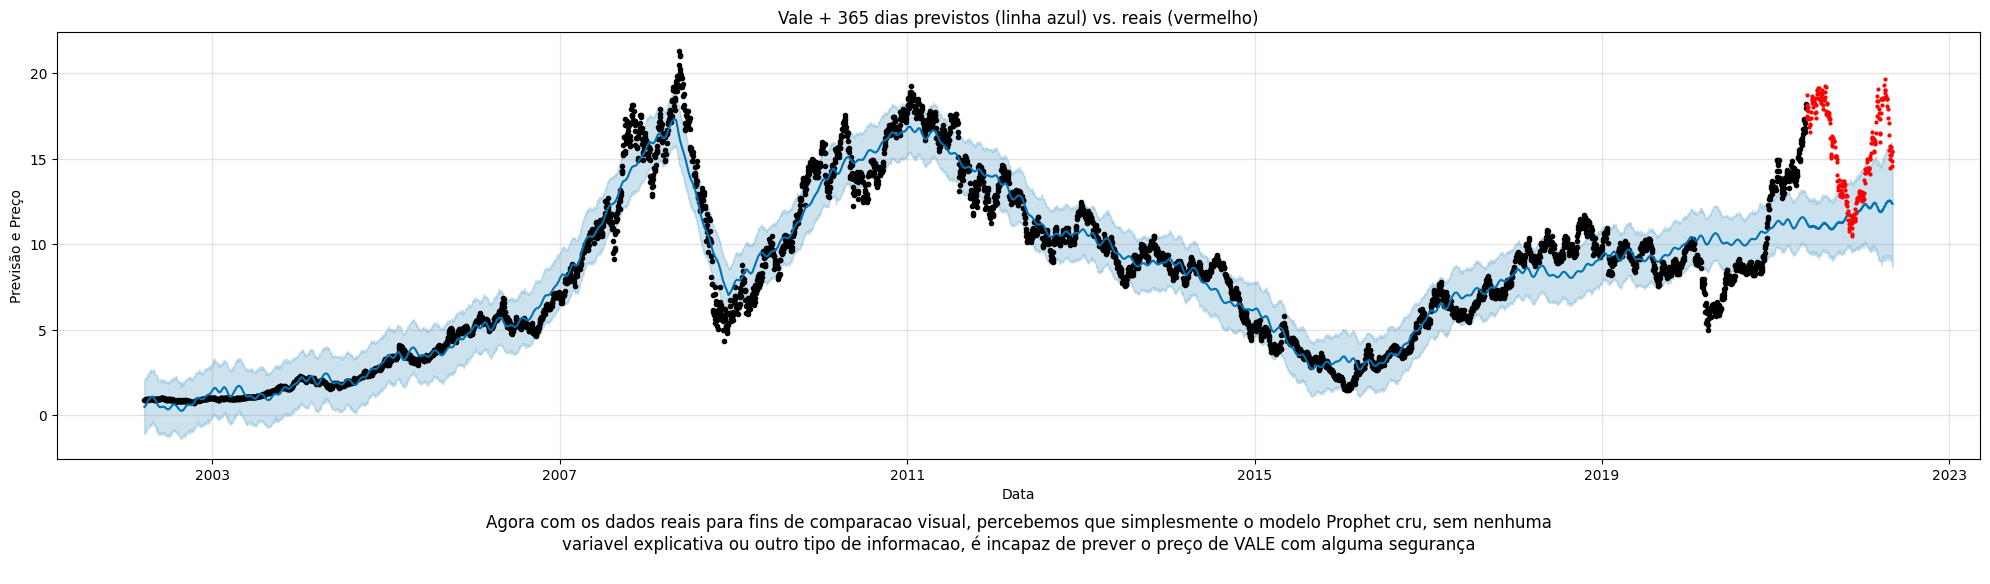

In [148]:
#Plotando os graficos do df_future1(vermelho) e m1 + forecast1(Preto + Azul) com matplotib para comparar

# Criar uma figura e um subplot
fig, axes = plt.subplots(figsize=(20, 5))

# Plotar a previsão (forecast1) gerada pelo modelo no subplot
m1.plot(forecast1, ax=axes)

# Plotar os dados de teste (df_test) no mesmo subplot
axes.plot(df_future1['ds'], df_future1['y'], 'ro', markersize=2)

# Adicionar título e rótulos dos eixos
axes.set_title("Vale + 365 dias previstos (linha azul) vs. reais (vermelho)")
axes.set_xlabel("Data")
axes.set_ylabel("Previsão e Preço")

# Adicionar texto abaixo dos gráficos
axes.text(0.5, -0.2, "Agora com os dados reais para fins de comparacao visual, percebemos que simplesmente o modelo Prophet cru, sem nenhuma\nvariavel explicativa ou outro tipo de informacao, é incapaz de prever o preço de VALE com alguma segurança\n", ha='center', va='center', transform=axes.transAxes, fontsize=12)

# Mostrar a figura
plt.show()

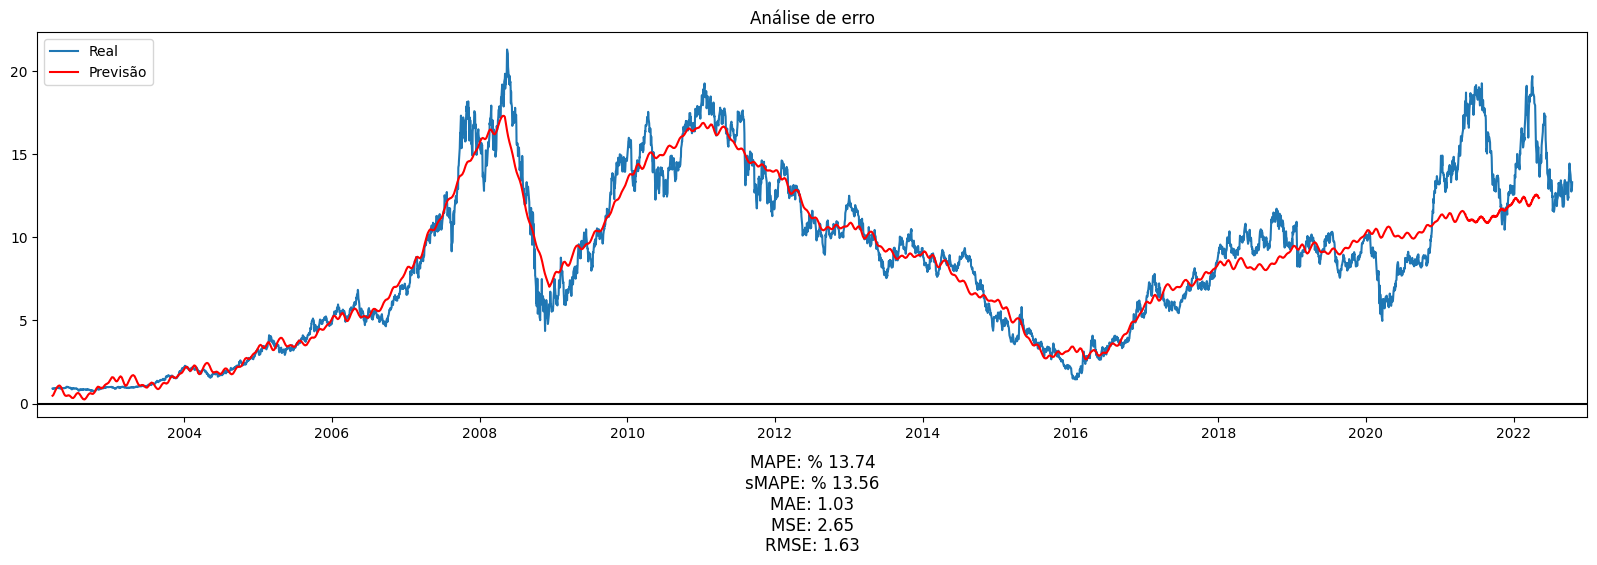

In [149]:
analise_de_erro(df, forecast1)

18:06:01 - cmdstanpy - INFO - Chain [1] start processing
18:06:03 - cmdstanpy - INFO - Chain [1] done processing


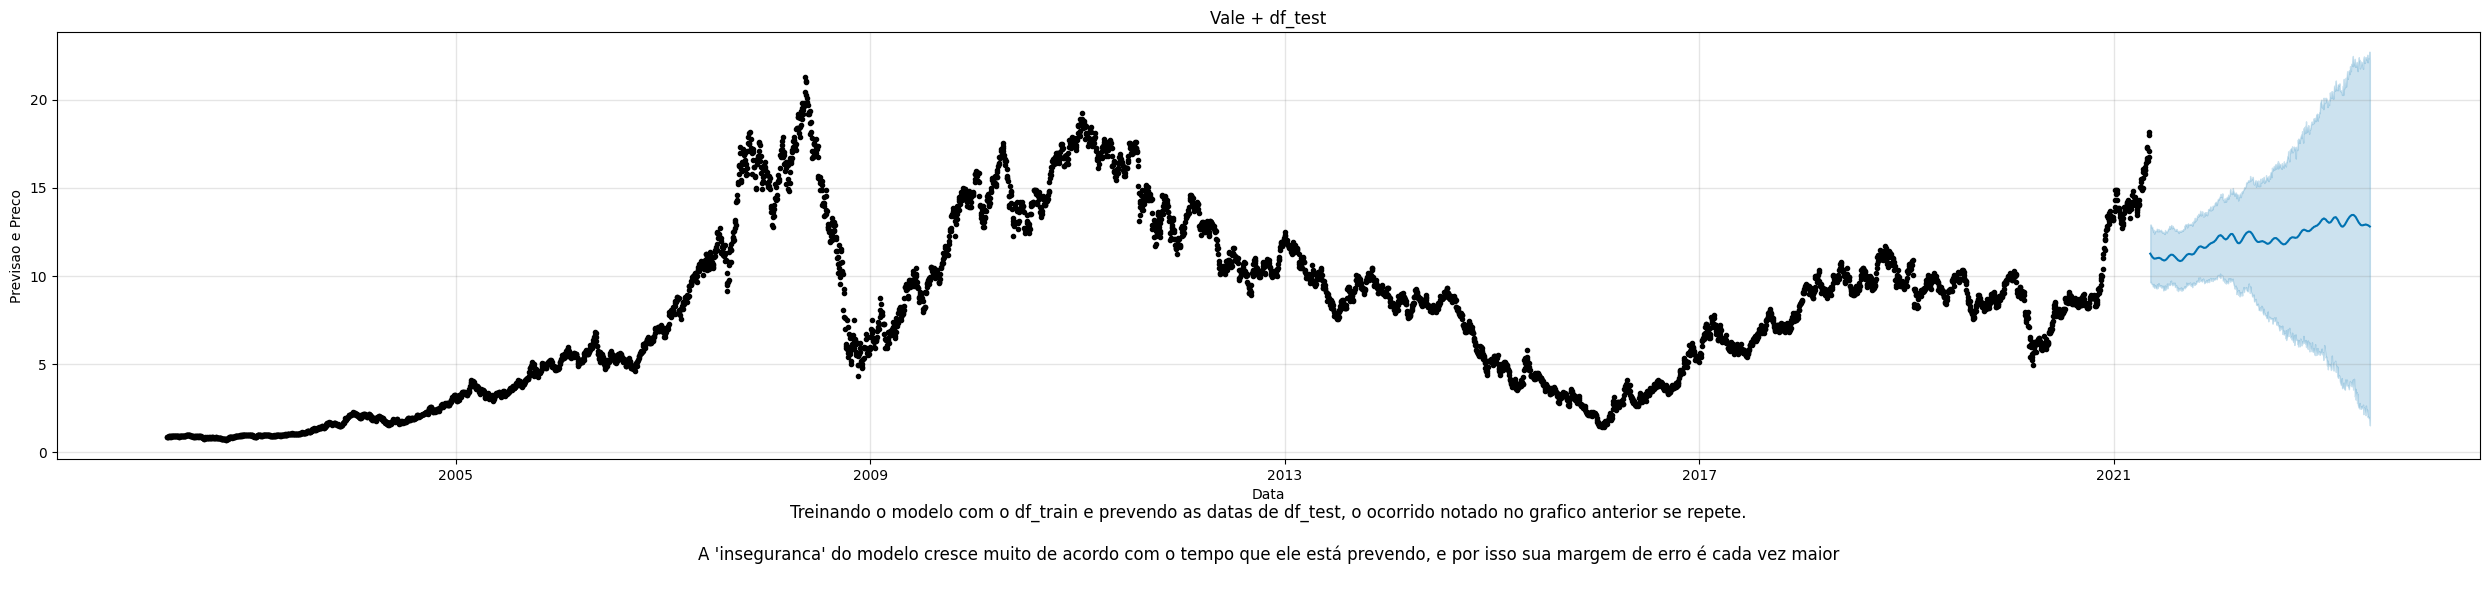

In [150]:
#METODO 2 - Treinando com df_train e prevendo df_test

#Treinando o modelo com o dataframe de treino
m2 = Prophet(daily_seasonality=True)
m2.fit(df_train)

#Fazendo a predicao para datas futuras, do df_test, usando o modelo treinado pelo df_train
forecast2 = m2.predict(df_test)

#m2.plot(test_pred);
plot_forecast(m2, forecast2,"Data", "Previsao e Preco", "Vale + df_test", "Treinando o modelo com o df_train e prevendo as datas de df_test, o ocorrido notado no grafico anterior se repete.\n\nA 'inseguranca' do modelo cresce muito de acordo com o tempo que ele está prevendo, e por isso sua margem de erro é cada vez maior")

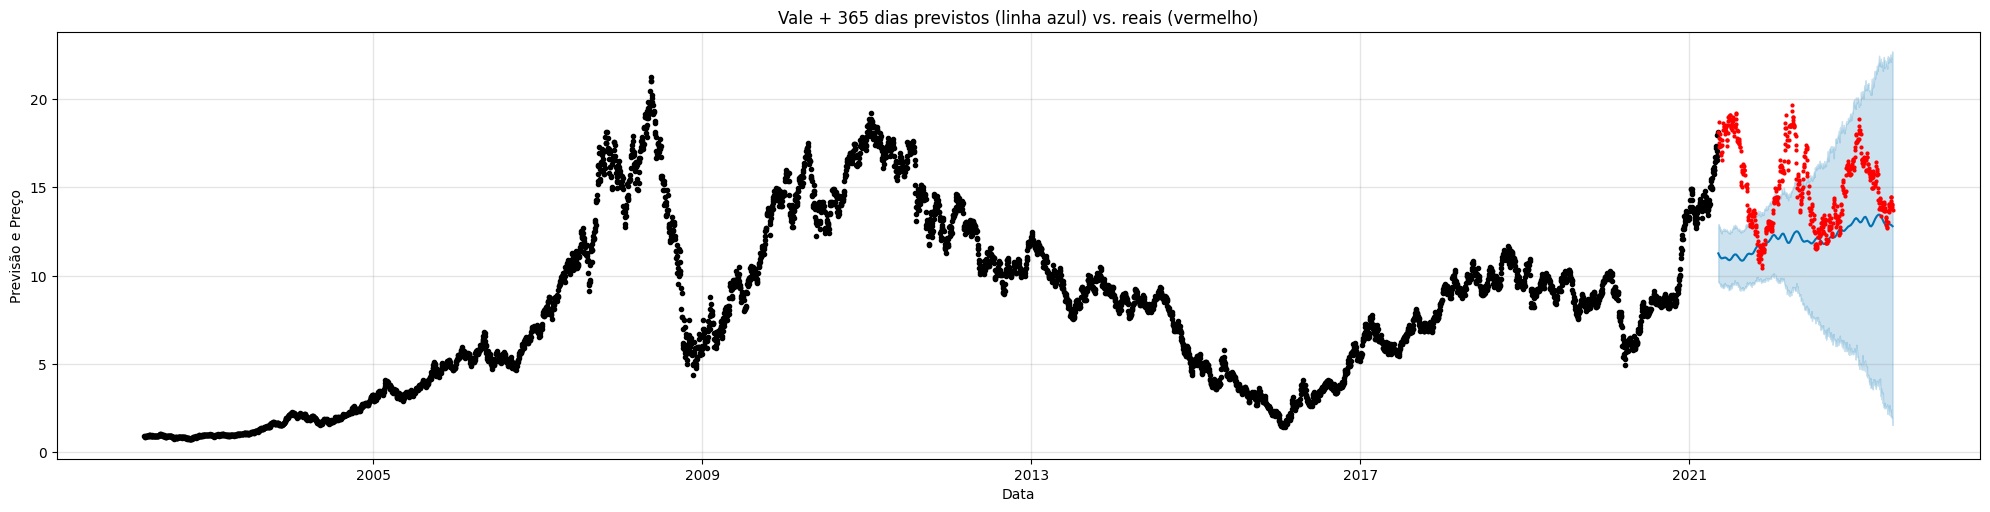

In [151]:
#Plotando os graficos do df_test(vermelho) e m2 + forecast2(Preto + Azul) com matplotib para comparar

# Criar uma figura e um subplot
fig, axes = plt.subplots(figsize=(20, 5))

# Plotar a previsão (test_pred) gerada pelo modelo no subplot
m2.plot(forecast2, ax=axes)

# Plotar os dados de teste (df_test) no mesmo subplot
axes.plot(df_test['ds'], df_test['y'], 'ro', markersize=2)

# Adicionar título e rótulos dos eixos
axes.set_title("Vale + 365 dias previstos (linha azul) vs. reais (vermelho)")
axes.set_xlabel("Data")
axes.set_ylabel("Previsão e Preço")

# Mostrar a figura
plt.show()


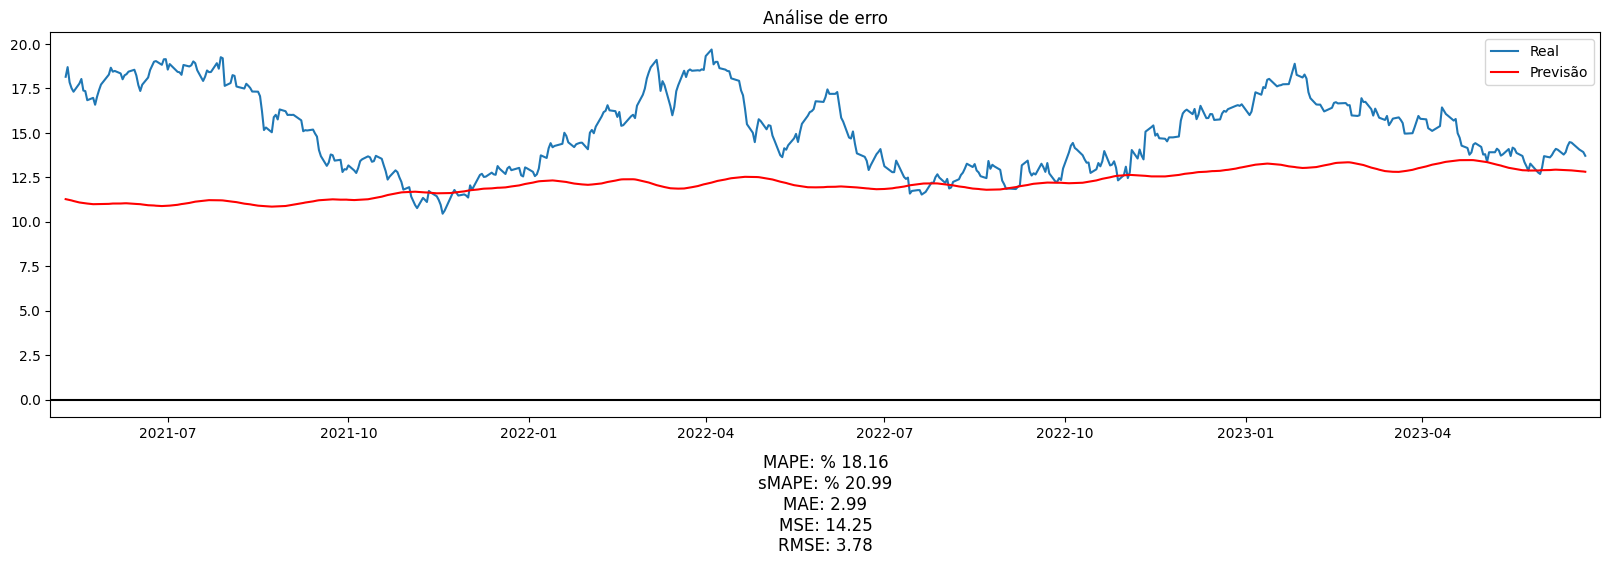

In [152]:
analise_de_erro(df_test, forecast2)

In [153]:
#METODO 3 - Prevendo o retorno -> df com diferença relativa ((p_t-p_{t-1} / p_t))

# Copiando df para df3
df3 = df_train.copy()
#df3 = df_train

print(df3.tail(5000))

# Calculando a diferença relativa
df3['y'] = df3['y'].pct_change()
#df3['y'] = (df_train['y'] - df_train['y'].shift(1)) / df_train['y']

# Remove colunas nan (Primeira coluna)
df3 = df3.dropna()

print(df3.tail(5000))


             ds          y
0    2002-03-21   0.902664
1    2002-03-22   0.874246
2    2002-03-25   0.874246
3    2002-03-26   0.897315
4    2002-03-27   0.911021
...         ...        ...
4812 2021-05-03  16.529451
4813 2021-05-04  16.768055
4814 2021-05-05  17.056023
4815 2021-05-06  17.977528
4816 2021-05-07  18.166763

[4817 rows x 2 columns]
             ds         y
1    2002-03-22 -0.031482
2    2002-03-25  0.000000
3    2002-03-26  0.026387
4    2002-03-27  0.015275
5    2002-03-28  0.005138
...         ...       ...
4812 2021-05-03 -0.001491
4813 2021-05-04  0.014435
4814 2021-05-05  0.017174
4815 2021-05-06  0.054028
4816 2021-05-07  0.010526

[4816 rows x 2 columns]


In [154]:
#Treinando o modelo com o dataframe de treino
m3 = Prophet(daily_seasonality=True)
m3.fit(df3)

#Criando um dataframe com datas futuras (365 a frente do tempo)
future3 = m3.make_future_dataframe(periods=365)

#Fazendo a predicao para datas futuras, do dataframe future3, usando o modelo treinado pelo df_train
forecast3 = m3.predict(future3)

18:06:04 - cmdstanpy - INFO - Chain [1] start processing
18:06:04 - cmdstanpy - INFO - Chain [1] done processing


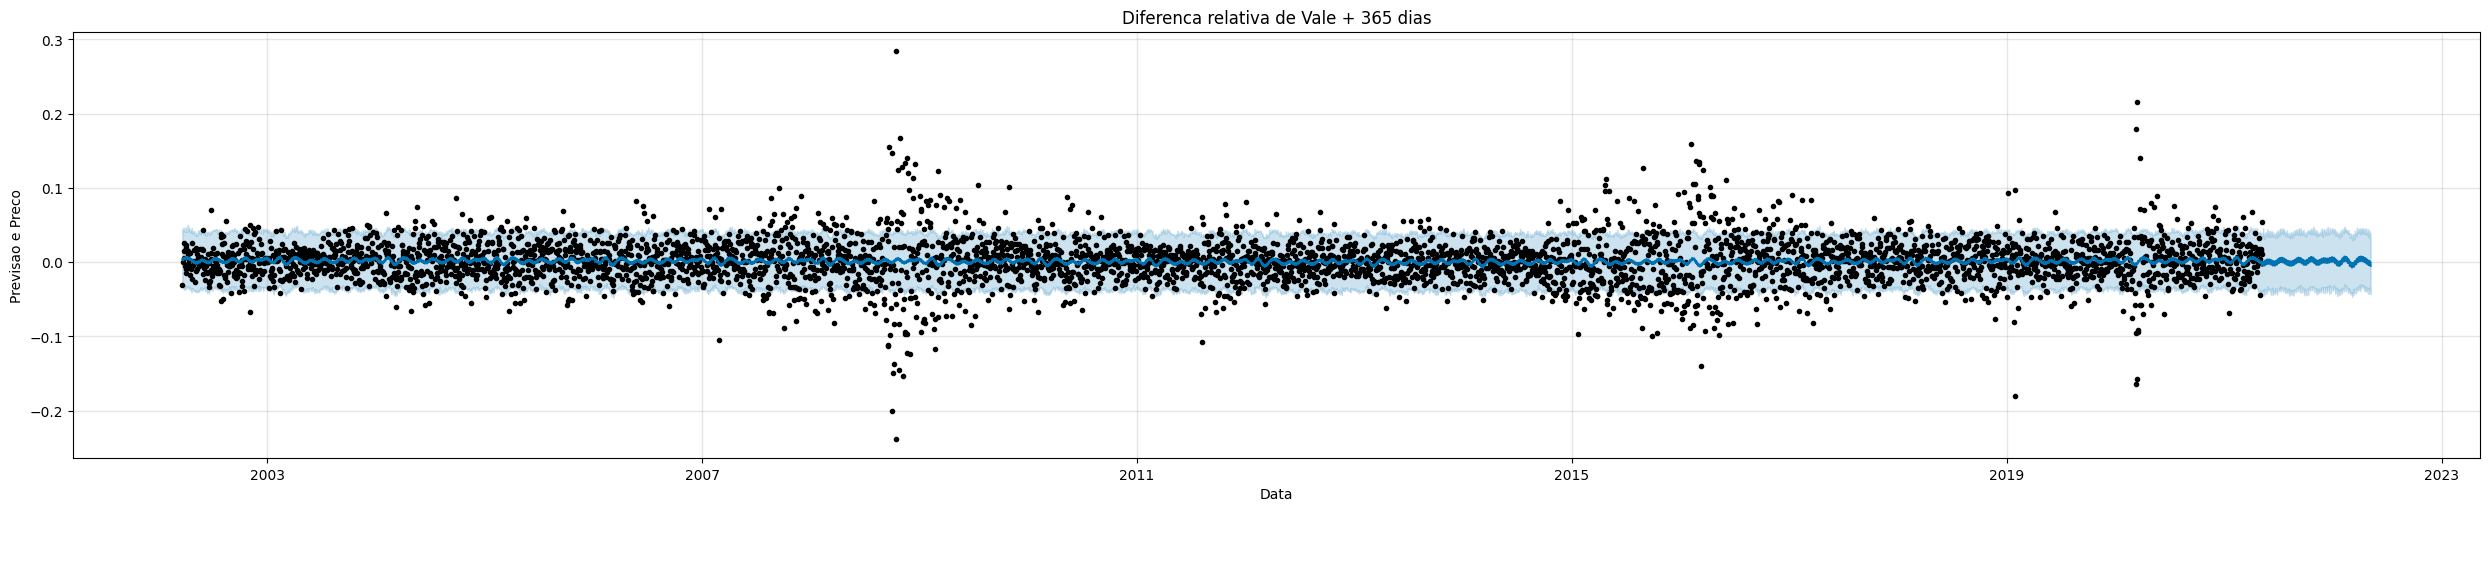

In [155]:
#m3.plot(forecast3)
plot_forecast(m3, forecast3,"Data", "Previsao e Preco", "Diferenca relativa de Vale + 365 dias", "")

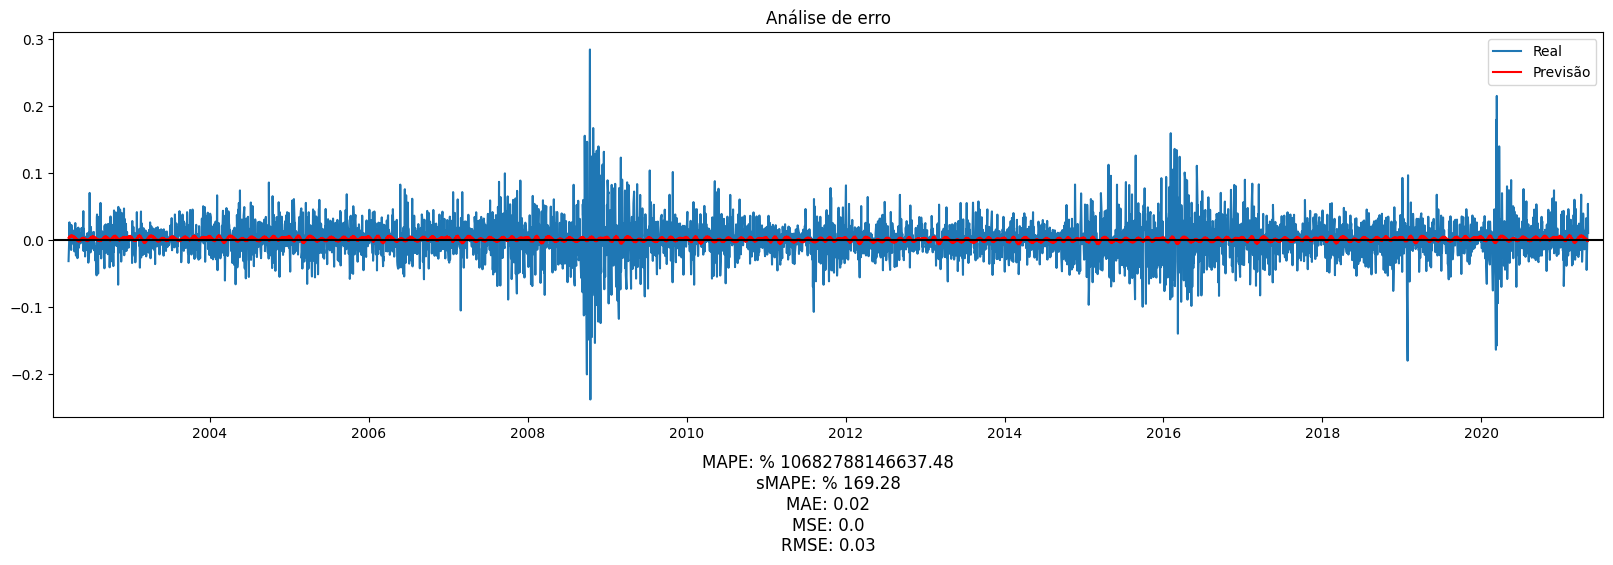

In [156]:
analise_de_erro(df3, forecast3)

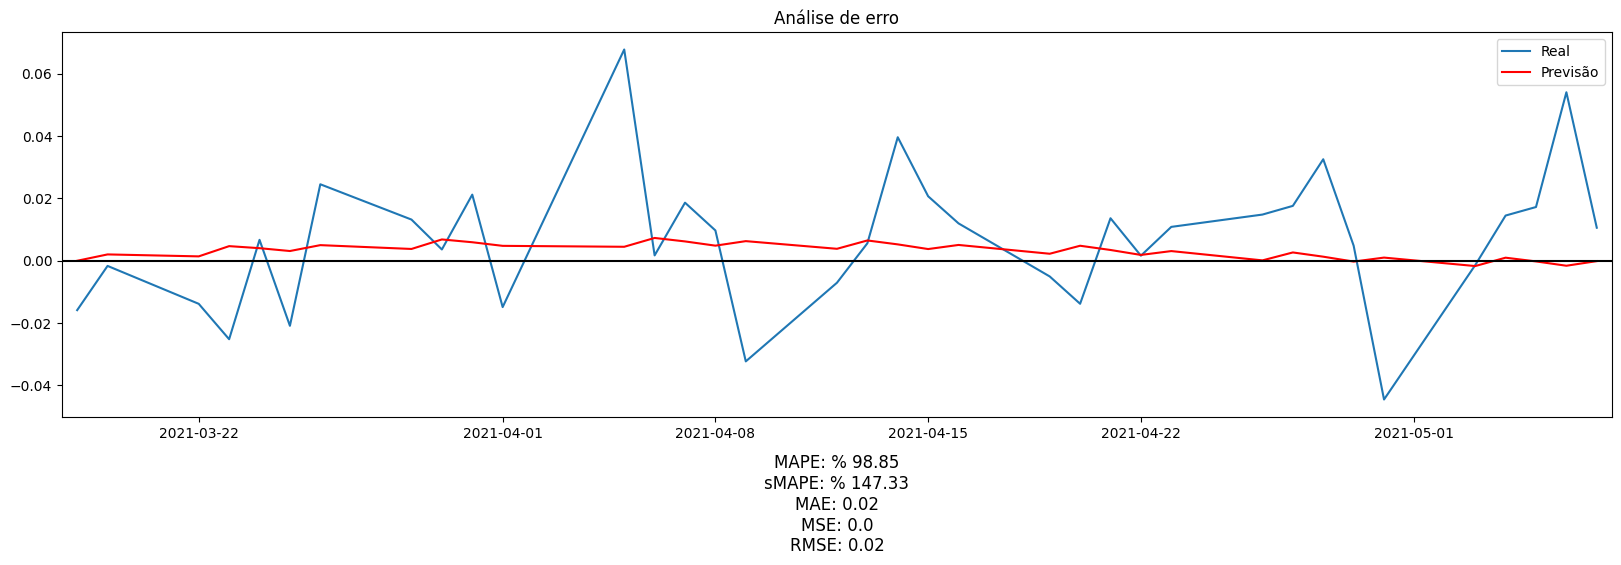

In [157]:
# Plot apenas do ultimo mes (df_train)
analise_de_erro(df3[4780:], forecast3[4780:])

In [158]:
#METODO 4 - Prevendo o log-retorno -> df com retorno logaritmico ln(p_t / p_{t-1})

# Copiando df para df4
df4 = df_train.copy()

print(df4.tail(5000))

# Calculando o retorno logaritmico
df4['y'] = np.log(df4['y'] / df4['y'].shift(1))

# Remove colunas nan (Primeira coluna)
df4 = df4.dropna()

print(df4.tail(5000))

             ds          y
0    2002-03-21   0.902664
1    2002-03-22   0.874246
2    2002-03-25   0.874246
3    2002-03-26   0.897315
4    2002-03-27   0.911021
...         ...        ...
4812 2021-05-03  16.529451
4813 2021-05-04  16.768055
4814 2021-05-05  17.056023
4815 2021-05-06  17.977528
4816 2021-05-07  18.166763

[4817 rows x 2 columns]
             ds         y
1    2002-03-22 -0.031988
2    2002-03-25  0.000000
3    2002-03-26  0.026045
4    2002-03-27  0.015160
5    2002-03-28  0.005125
...         ...       ...
4812 2021-05-03 -0.001492
4813 2021-05-04  0.014332
4814 2021-05-05  0.017028
4815 2021-05-06  0.052619
4816 2021-05-07  0.010471

[4816 rows x 2 columns]


In [159]:
#Treinando o modelo com o dataframe de treino
m4 = Prophet(daily_seasonality=True)
m4.fit(df4)

#Criando um dataframe com datas futuras (365 a frente do tempo)
future4 = m4.make_future_dataframe(periods=365)

#Fazendo a predicao para datas futuras, do dataframe future4, usando o modelo treinado pelo df_train
forecast4 = m4.predict(future4)

18:06:06 - cmdstanpy - INFO - Chain [1] start processing
18:06:06 - cmdstanpy - INFO - Chain [1] done processing


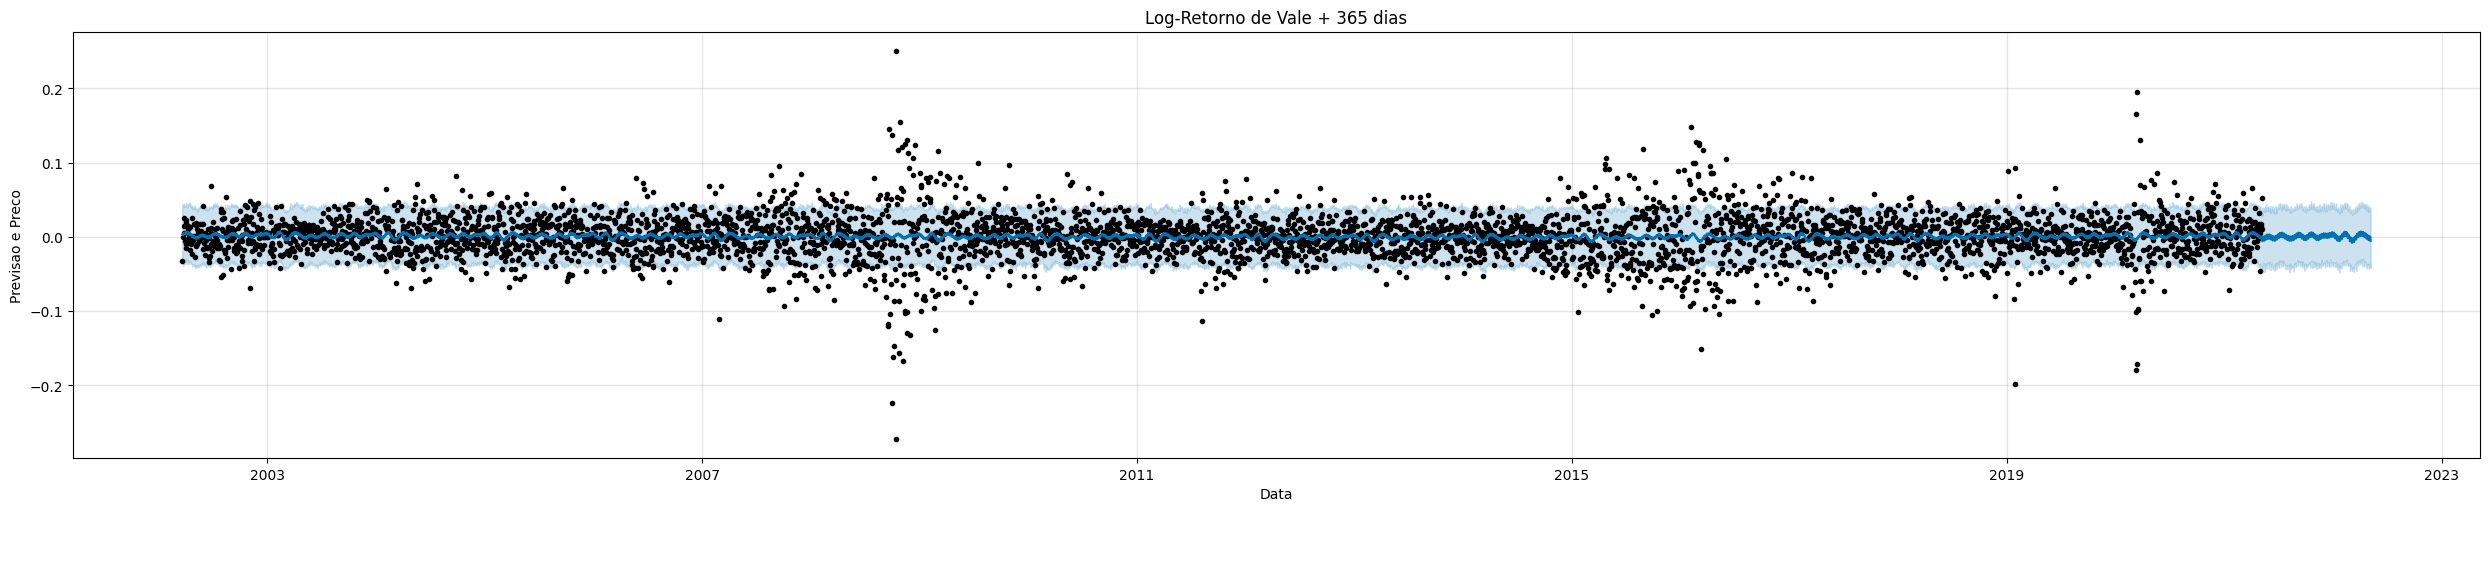

In [160]:
#m4.plot(forecast4)
plot_forecast(m4, forecast4,"Data", "Previsao e Preco", "Log-Retorno de Vale + 365 dias", "")

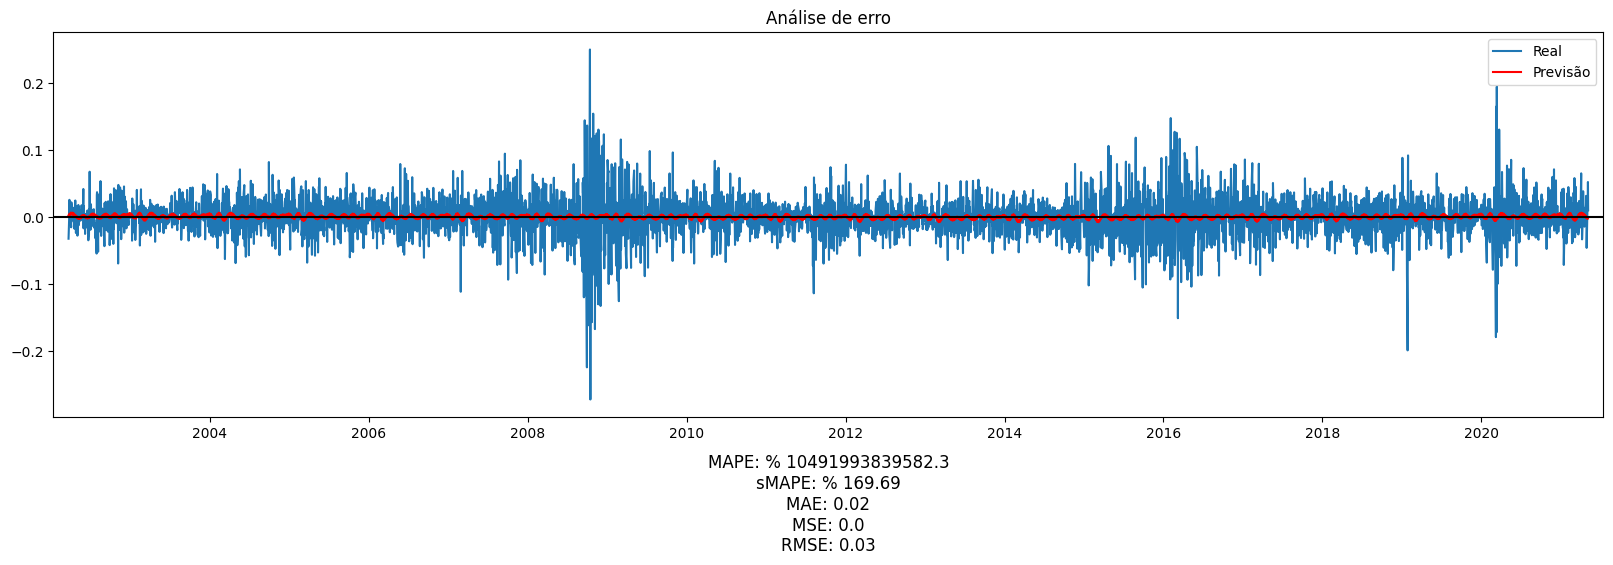

In [161]:
analise_de_erro(df4, forecast4)

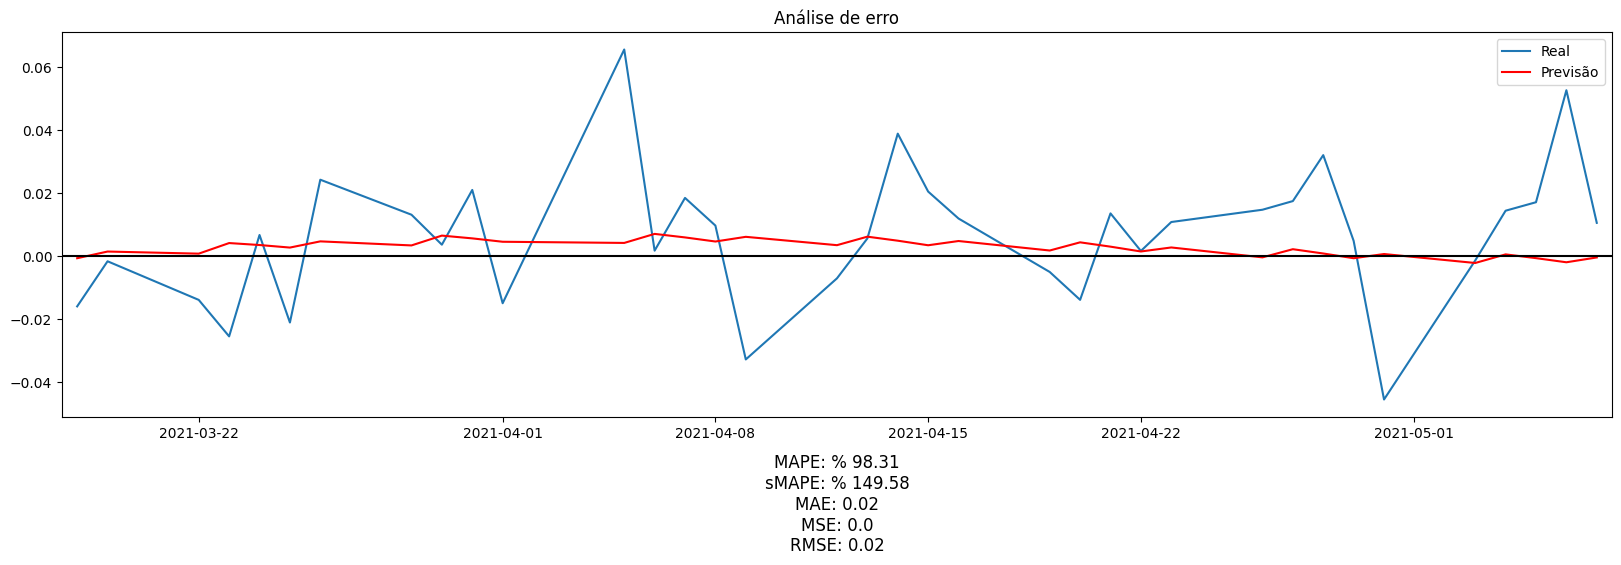

In [162]:
# Plot apenas do ultimo mes (df_train)
analise_de_erro(df4[4780:], forecast4[4780:])